# Rate Networks

In [2]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

try:
    import brian2
except ImportError:
    !pip install brian2
    
from brian2 import *
prefs.codegen.target = 'numpy'


\begin{equation}
F(x;\alpha,\theta) = \left(1+\text{e}^{-\frac{x-\theta}{\alpha}}\right)^{-1} - \left(1+\text{e}^{\frac{\theta}{\alpha}}\right)^{-1}
\end{equation}

interactive(children=(FloatSlider(value=0.2, description='alpha', max=1.0, min=0.01, step=0.01), IntSlider(val…

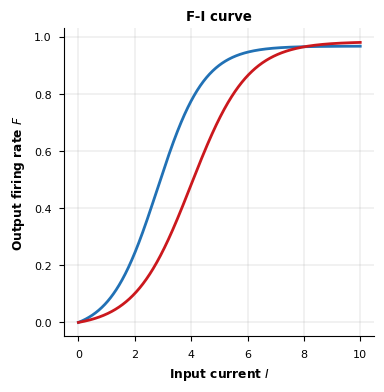

In [3]:
def nonlinearity_f(x, alpha, theta):    
    return (1 + np.exp(-alpha*(x - theta)))**-1 - (1 + np.exp(alpha*theta))**-1

fig, ax = plt.subplots(figsize = (4,4))
X = np.linspace(0,10,1000)
ax.plot(X, nonlinearity_f(X, alpha=1.2, theta=2.8), color = '#2171B5')
ax.plot(X, nonlinearity_f(X, alpha=1.0, theta=4.0), c='#CB181D')
ax.set(
    title = 'F-I curve',
    xlabel = 'Input current $I$',
    ylabel = 'Output firing rate $F$',
);


def interactive_f(alpha=0.2, theta=40):
    
    x_max = 80
    fig, ax = plt.subplots(figsize = (14,8))
    X = np.linspace(-0.1,x_max,100)
    ax.plot(X, nonlinearity_f(X, alpha=alpha, theta=theta), color='#6baed6', linewidth = 3)
    
    y_theta = nonlinearity_f(theta, alpha=alpha, theta=theta)
    
    ax.plot([theta,theta],[0,y_theta],
           linestyle = '--', c = '#e34a33', linewidth=1, label = r'threshold $\theta$')
    
    # we want to visualize the gain of the 
    
    diff = 8
    
    ax.plot([theta-diff,theta+diff],[y_theta-diff*alpha/4, y_theta+diff*alpha/4],
           linestyle = '--', c = 'k', linewidth=1, label = r'linear function with gain $\alpha/4$')
    
    ax.set(
        title = 'F-I curve',
        xlabel = 'Input current',
        ylabel = 'Output rate',
        ylim = [-0.05,1.05],
        xlim = [-0.05*x_max,x_max*1.05]
    );
    ax.legend()
    
widgets.interactive(interactive_f, alpha = (0.01,1,0.01), theta=(0,60,10))

In [15]:
def run_input_to_nonlinearity(r_0 = 0.3, I_ext = 20, alpha=0.5,theta=10):
    
    t_list = [0]
    r_list = [r_0]
    
    dt = 0.1
    tau = 20
    for ii in range(1500):
        t_list.append(t_list[-1]+dt)
        r_list.append(r_list[-1] + dt*(-r_list[-1]+nonlinearity_f(I_ext,alpha=alpha,theta=theta))/tau)
        
    return t_list, r_list

def show_input_to_nonlinearity(
    t_list, 
    r_list,
    color = 'k',
    ax = None):
    if ax == None:
        fig, ax = plt.subplots()

    ax.plot(t_list, r_list, color=color)
    ax.set_xticks([0,75,150])
    ax.set_xticklabels([0,75,150],fontsize=14)
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels([0,0.5,1],fontsize=14)
    ax.set_xlabel('time in ms', fontsize=16)
    ax.set_ylabel('firing rate $r$', fontsize=16)
    
    return ax

In [16]:
def interctive_input_to_nonlinearity(r_0 = 0.3, I_ext = 20):
    t_list, r_list = run_input_to_nonlinearity(r_0 = r_0, I_ext = I_ext)
    show_input_to_nonlinearity(t_list, r_list)
    
widgets.interactive(interctive_input_to_nonlinearity, r_0 = (0,1,0.05), I_ext = (0,40,1))

interactive(children=(FloatSlider(value=0.3, description='r_0', max=1.0, step=0.05), IntSlider(value=20, descr…

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F(w_{EE}r_E -w_{EI}r_I + I_E;\alpha_E,\theta_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F(w_{IE}r_E -w_{II}r_I + I_I;\alpha_I,\theta_I) \qquad (1)
\end{align}

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I_I) \qquad (1)
\end{align}

In [41]:
class RecurrentNetwork(object):
    """
    This class can create a recurrent network, run simulations and visualize the results
    """
    def __init__(self, 
                    w = 5,
                    alpha = 4,
                    theta = 13,
                    tau = 11,
                    dt = 1
    ):
        '''This function is executed when we create an object from that class'''
        super(RecurrentNetwork, self).__init__()
        
        self.w = w
        self.alpha = alpha
        self.theta = theta
        self.tau = tau
        self.dt = dt

        self.t_list = []
        self.r_list = []
        

    def compute_drdt(self, r, I_ext):
        # Calculate drdt
        drdt = (-r + nonlinearity_f(self.w * r + I_ext, self.alpha, self.theta)) / self.tau
        return drdt


    def run_simulation(self, r_0 = 0.3, I_ext = 20, time_steps = 1500):

        self.t_list = [0]
        self.r_list = [r_0]

        for ii in range(time_steps):
            drdt = self.compute_drdt(r = self.r_list[-1], I_ext = I_ext)
            self.r_list.append(self.r_list[-1] + self.dt*drdt)
            self.t_list.append(self.t_list[-1]+self.dt)


    def show_simulation_result(
        self,
        color = 'k',
        linewidth = 2,
        ax = None):
        if ax == None:
            fig, ax = plt.subplots()

        ax.plot(self.t_list, self.r_list, color=color, linewidth=linewidth)
        ax.set_xticks([0,75,150])
        ax.set_xticklabels([0,75,150],fontsize=14)
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels([0,0.5,1],fontsize=14)
        ax.set_xlabel('time in ms', fontsize=16)
        ax.set_ylabel('firing rate $r$', fontsize=16)

        return ax
    
    def show_phase_plane(self,
                        I_ext = 0.5):
        
        # Define a vector of r values and the simulation parameters
        r = np.linspace(0, 1, 1000)

        # Compute dr/dt
        drdt = compute_drdt(r, I_ext = I_ext, w = self.w, alpha = self.alpha, theta = self.theta, tau = self.tau)

        fig, ax = plt.subplots()
        ax.plot(r, drdt)
        ax.plot([0,1],[0,0],linestyle = '--', color = 'k')

        x_ticks = [0,0.5,1]
        y_ticks = [-0.003, 0, 0.003]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontsize=14)
        ax.set_xlabel('$r$', fontsize=16, fontweight='bold')
        ax.set_ylabel(r'$\frac{dr}{dt}$', fontsize=22, rotation=0, fontweight='bold')
    

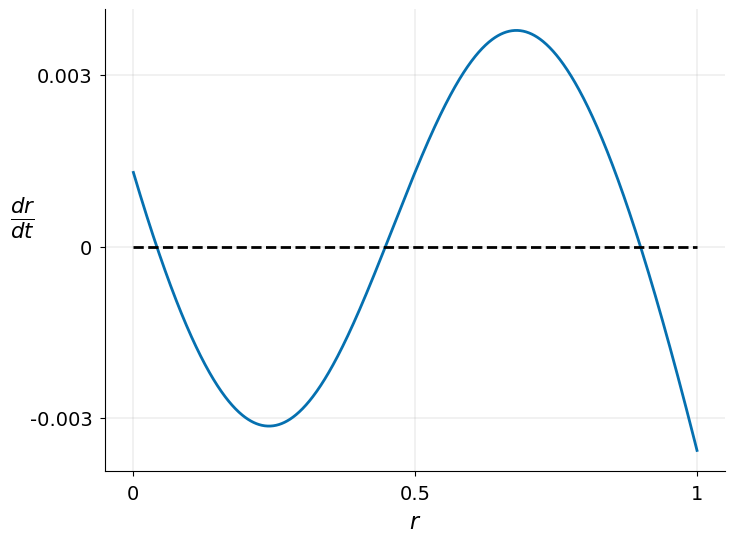

In [42]:
example = RecurrentNetwork(w = 5, alpha = 1.2, theta = 2.8, tau = 20)
example.show_phase_plane()

<AxesSubplot:xlabel='time in ms', ylabel='firing rate $r$'>

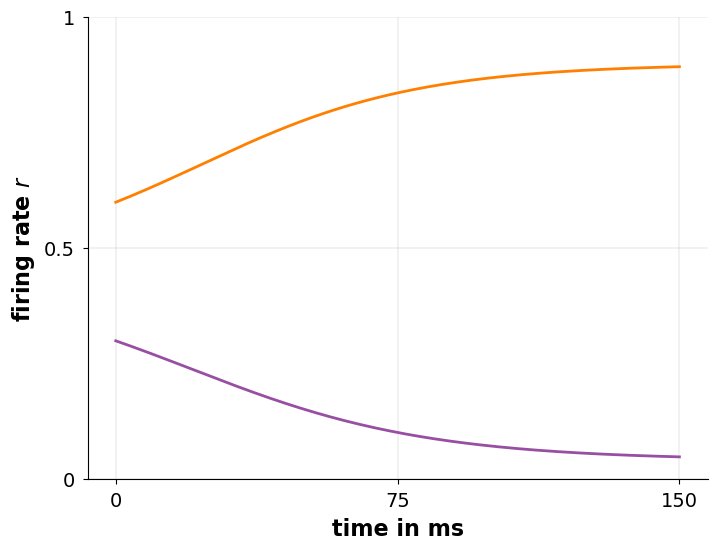

In [43]:
example = RecurrentNetwork(w = 5, alpha = 1.2, theta = 2.8, tau = 20)
example.run_simulation(r_0 = 0.3, I_ext = 0.5, time_steps = 150)
ax = example.show_simulation_result(color = '#984ea3',ax = None)
example.run_simulation(r_0 = 0.6, I_ext = 0.5, time_steps = 150)
example.show_simulation_result(color = '#ff7f00',ax = ax )

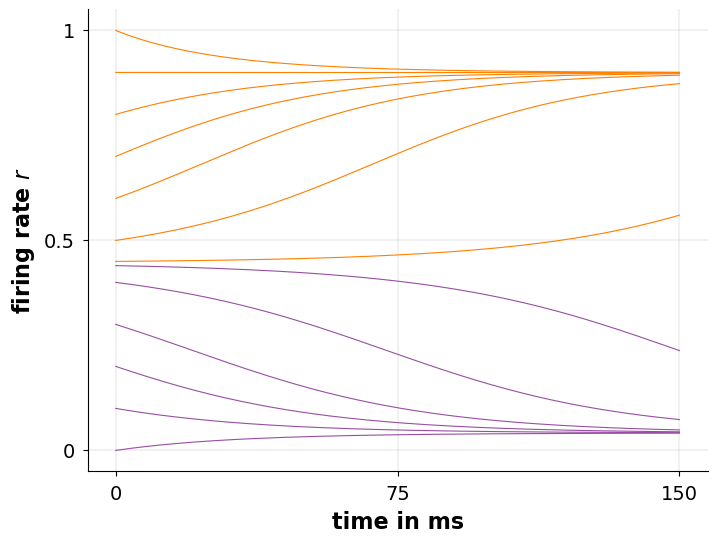

In [44]:
fig, ax = plt.subplots()
example = RecurrentNetwork(w = 5, alpha = 1.2, theta = 2.8, tau = 20)
for r_0 in [0, 0.1, 0.2, 0.3, 0.4, 0.44]:
    example.run_simulation(r_0 = r_0, I_ext = 0.5, time_steps = 150)
    example.show_simulation_result(color = '#984ea3', linewidth = 0.8,ax = ax)
for r_0 in [0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    example.run_simulation(r_0 = r_0, I_ext = 0.5, time_steps = 150)
    example.show_simulation_result(color = '#ff7f00', linewidth = 0.8,ax = ax)

In [107]:
class EI_network(object):
    """
    This class can create E-I networks, run simulations and visualize the results
    """
    def __init__(self, 
                    w_EE = 9,
                    w_EI = 4,
                    w_II = 13,
                    w_IE = 11,

                    tau_E = 20,
                    tau_I = 10,

                    alpha_E = 1.2,
                    theta_E = 2.8,

                    alpha_I = 1.0,
                    theta_I = 4.0,

                    dt = 1 
    ):
        '''This function is executed when we create an object from that class'''
        super(EI_network, self).__init__()
         
        self.w_EE = w_EE 
        self.w_EI = w_EI 
        self.w_II = w_II 
        self.w_IE = w_IE 

        self.tau_E = tau_E 
        self.tau_I = tau_I 

        self.alpha_E = alpha_E 
        self.theta_E = theta_E 
        self.alpha_I = alpha_I 
        self.theta_I = theta_I 
        self.dt = dt   
    
    
        self.r_E_list = []
        self.r_I_list = []
        self.t_list = []

    
    def dr_dt(self, r_E, r_I, I_E, I_I):

        input_current_E = self.w_EE * r_E - self.w_EI * r_I + I_E 
        drE_dt = self.dt * (- r_E + nonlinearity_f(input_current_E, alpha=self.alpha_E, theta=self.theta_E))/self.tau_E

        input_current_I = self.w_IE * r_E - self.w_II * r_I + I_I 
        drI_dt = self.dt * (- r_I + nonlinearity_f(input_current_I, alpha=self.alpha_I, theta=self.theta_I))/self.tau_I

        return drE_dt, drI_dt
    
    def run_simulation(self, r_E0, r_I0, I_E = 0, I_I = 0, timesteps=201):    

        self.t_list = [0]
        self.r_E_list = [r_E0]
        self.r_I_list = [r_I0]       
        
        for ii in range(timesteps):
            
            r_E = self.r_E_list[-1]
            r_I = self.r_I_list[-1]
        
            
            dr_E_dt, dr_I_dt = self.dr_dt(r_E, r_I, I_E, I_I)
            
            # store in lists
            self.r_E_list.append(r_E + dr_E_dt)
            self.r_I_list.append(r_I + dr_I_dt)
            self.t_list.append(self.t_list[-1]+dt)


    def show_sim_results_current_v_time_lecture_plot(self, ax = None, linestyle='-'):
        
        if ax == None:
            fig, ax = plt.subplots()
        x_ticks = [0,100,200]
        y_ticks = [0,0.5,1]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontsize=14)
        ax.set_xlabel('time in ms', fontsize=16)
        ax.set_ylabel('firing rate $r$', fontsize=16)
        ax.set(
            ylim = [-0.1,1.1])

        

        ax.plot(self.t_list, self.r_E_list, color='#2171B5', linewidth = 1.5, linestyle = linestyle)
        ax.plot(self.t_list, self.r_I_list, color='#CB181D', linewidth = 1.5, linestyle = linestyle)
        
        
        return ax
        
        
    def show_sim_results_phase_plane(self, ax = None, color = '#984ea3', linestyle='-' ):
        
        if ax == None:
            fig, ax = plt.subplots()
        x_ticks = [0,0.5, 1]
        y_ticks = [0,0.25,0.5]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontsize=14)
        ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
        ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)

        ax.plot(self.r_E_list, self.r_I_list, linewidth = 1.2, color = color, linestyle = linestyle)
        
        
        return ax



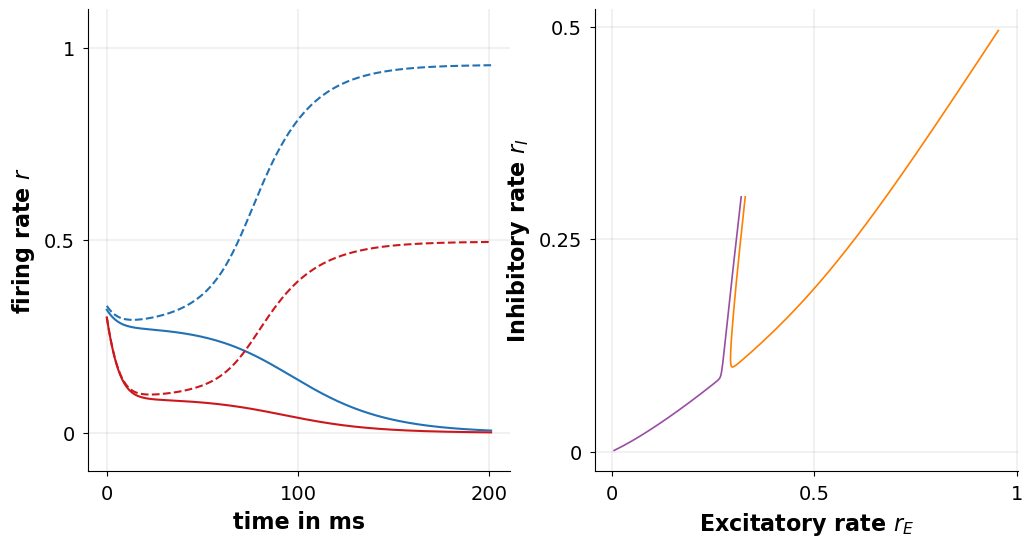

In [84]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

lecture_network = EI_network()
lecture_network.run_simulation(r_E0 = 0.32, r_I0 = 0.3)
lecture_network.show_sim_results_current_v_time_lecture_plot(linestyle = '-', ax = ax1)
lecture_network.show_sim_results_phase_plane( color = '#984ea3', ax = ax2)


lecture_network.run_simulation(r_E0 = 0.33, r_I0 = 0.3)
lecture_network.show_sim_results_current_v_time_lecture_plot(ax = ax1, linestyle = '--')
lecture_network.show_sim_results_phase_plane(ax = ax2, color = '#ff7f00');

In [109]:
def F_inv(x, a, theta):
    # Calculate Finverse (ln(x) can be calculated as np.log(x))
    F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

    return F_inverse

class EI_network_extended(EI_network):
    """
    This class can create E-I networks, run simulations and visualize the results
    """
    def __init__(self, **params):
        '''This function is executed when we create an object from that class'''
        super(EI_network_extended, self).__init__(**params)
        
        
    def get_E_nullcline(self, r_E, I_E):
        # calculate rI for E nullclines on rI
        r_I = 1 / self.w_EI * (self.w_EE * r_E - F_inv(r_E, self.alpha_E, self.theta_E) + I_E)

        return r_I


    def get_I_nullcline(self, r_I, I_I):
        # calculate rE for I nullclines on rI
        r_E = 1 / self.w_IE * (self.w_II * r_I + F_inv(r_I, self.alpha_I, self.theta_I) - I_I)

        return r_E
    
    def show_nullclines_in_phase_plane(self, I_E = 0, I_I = 0, ax = None):
        
        if ax == None:
            fig, ax = plt.subplots()
            
        # Set parameters
        Exc_null_rE = np.linspace(-0.01, 0.96, 100)
        Inh_null_rI = np.linspace(-.01, 0.8, 100)
        
        # Compute nullclines
        Exc_null_rI = self.get_E_nullcline(Exc_null_rE, I_E)
        Inh_null_rE = self.get_I_nullcline(Inh_null_rI, I_I)

        ax.plot(Exc_null_rE,Exc_null_rI, color='#2171B5', linewidth = 1.5, label = 'E-nullcline')
        ax.plot(Inh_null_rE,Inh_null_rI, color='#CB181D', linewidth = 1.5, label = 'I-nullcline')
        x_ticks = [0,0.5, 1]
        y_ticks = [0,0.5,1]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontsize=14)
        ax.set_xlabel('Excitatory rate $r_E$', fontsize=16)
        ax.set_ylabel('Inhibitory rate $r_I$', fontsize=16)
        ax.set_xlim([np.min(Inh_null_rE)*1.3,1])
        
        return ax
        


    def show_vectors_in_phase_plane(self, ax, I_E = 0, I_I = 0):
        

        EI_grid = np.linspace(-0.2, 1., 20)
        r_E, r_I = np.meshgrid(EI_grid, EI_grid)
        drEdt, drIdt = self.dr_dt(r_E, r_I, I_E = I_E, I_I = I_I)
        n_skip = 2
        ax.quiver(r_E[::n_skip, ::n_skip], r_I[::n_skip, ::n_skip],
                 drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
                 angles='xy', scale_units='xy', scale=1, facecolor='k', width = 0.003)




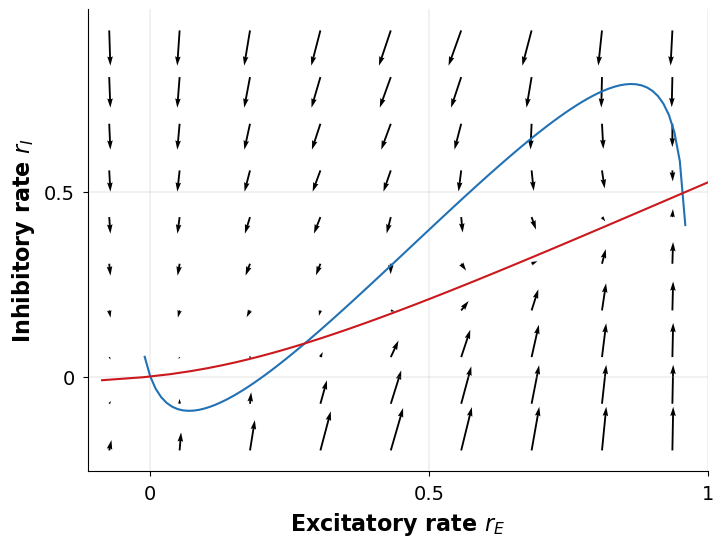

In [110]:
example = EI_network_extended()
ax = example.show_nullclines_in_phase_plane()
example.show_vectors_in_phase_plane(ax=ax)

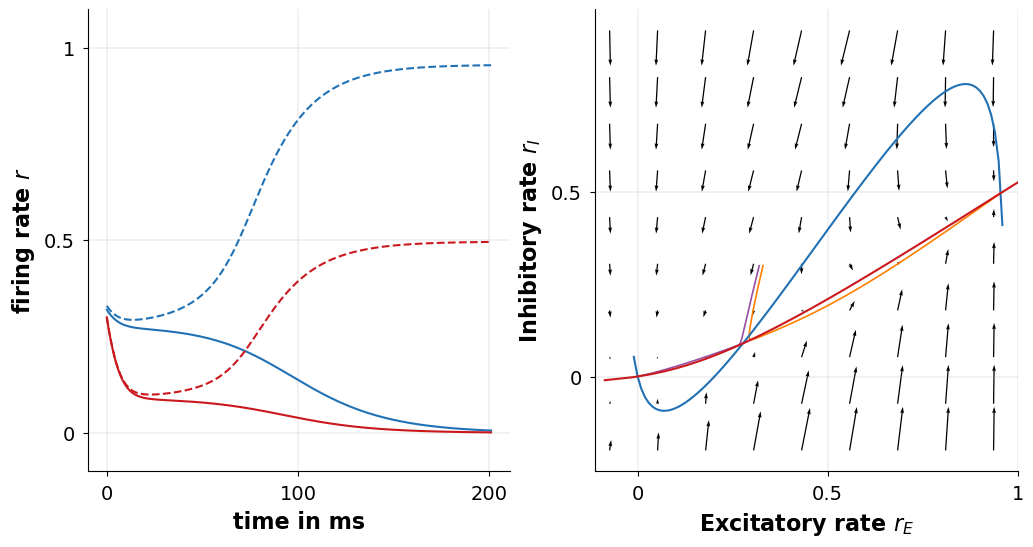

In [111]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

lecture_network = EI_network_extended()
lecture_network.run_simulation(r_E0 = 0.32, r_I0 = 0.3)
lecture_network.show_sim_results_current_v_time_lecture_plot(linestyle = '-', ax = ax1)
lecture_network.show_sim_results_phase_plane( color = '#984ea3', ax = ax2)

lecture_network.run_simulation(r_E0 = 0.33, r_I0 = 0.3)
lecture_network.show_sim_results_current_v_time_lecture_plot(ax = ax1, linestyle = '--')
lecture_network.show_sim_results_phase_plane(ax = ax2, color = '#ff7f00');

lecture_network.show_nullclines_in_phase_plane(ax=ax2)
lecture_network.show_vectors_in_phase_plane(ax=ax2)

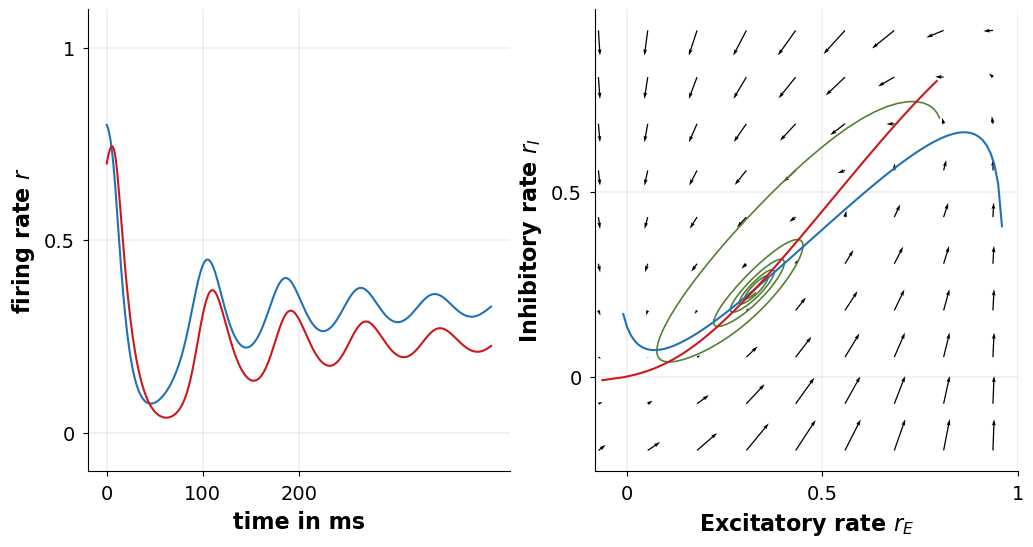

In [112]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

lecture_network = EI_network_extended(
    w_EE = 9 ,
    w_EI = 6,
    w_II = 7,
    w_IE = 14,
    tau_E = 10, 
    tau_I = 14)

I_E = 0.8
I_I = 0
lecture_network.run_simulation(r_E0 = 0.8, r_I0 = 0.7, I_E = I_E, I_I = I_I, timesteps = 400)
lecture_network.show_sim_results_current_v_time_lecture_plot(linestyle = '-', ax = ax1)
lecture_network.show_sim_results_phase_plane( color = '#548235', ax = ax2)

lecture_network.show_nullclines_in_phase_plane(ax=ax2,I_E = I_E, I_I = I_I)
lecture_network.show_vectors_in_phase_plane(ax=ax2, I_E = I_E, I_I = I_I)

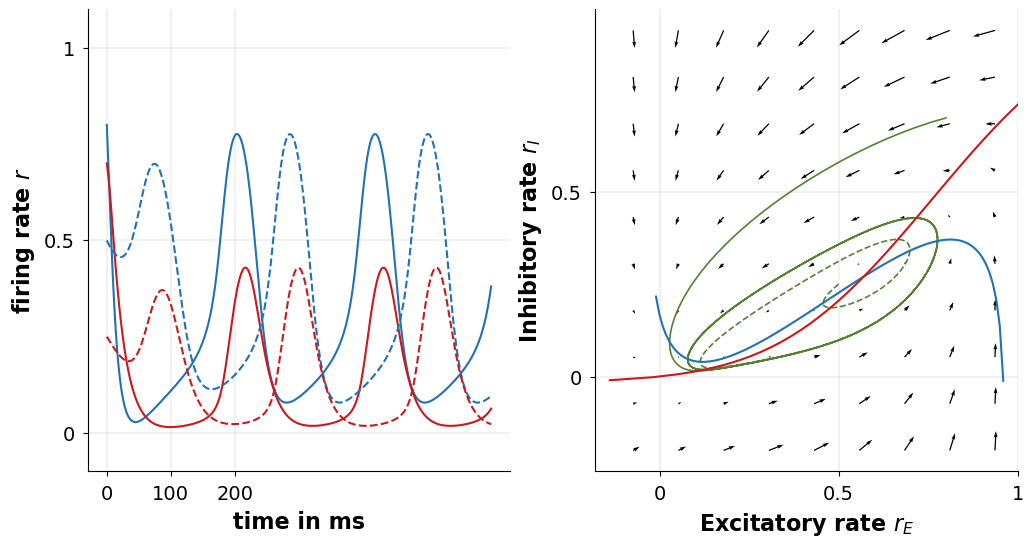

In [113]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

lecture_network = EI_network_extended(
    w_EE = 6.4 ,
    w_EI = 4.8,
    w_II = 1.2,
    w_IE = 6,
    tau_E = 10,
    tau_I = 20)

I_E = 0.8
I_I = 0

lecture_network.run_simulation(r_E0 = 0.8, r_I0 = 0.7, I_E = I_E, I_I = I_I, timesteps = 600)
lecture_network.show_sim_results_current_v_time_lecture_plot(linestyle = '-', ax = ax1)
lecture_network.show_sim_results_phase_plane( color = '#548235', ax = ax2)

lecture_network.run_simulation(r_E0 = 0.5, r_I0 = 0.25, I_E = I_E, I_I = I_I, timesteps = 600)
lecture_network.show_sim_results_current_v_time_lecture_plot(linestyle = '--', ax = ax1)
lecture_network.show_sim_results_phase_plane( color = '#548235', ax = ax2, linestyle='--')

lecture_network.show_nullclines_in_phase_plane(ax=ax2,I_E = I_E, I_I = I_I)
lecture_network.show_vectors_in_phase_plane(ax=ax2, I_E = I_E, I_I = I_I)

WARNING    'dt' is an internal variable of group 'poissongroup_2', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'poissongroup_3', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'excitatory_connections', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'inhibitory_connections', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'rec_e_e', but also exists in the run namespace with the value 5. The internal var

TypeError: float() argument must be a string or a number, not 'PopulationRateMonitor'

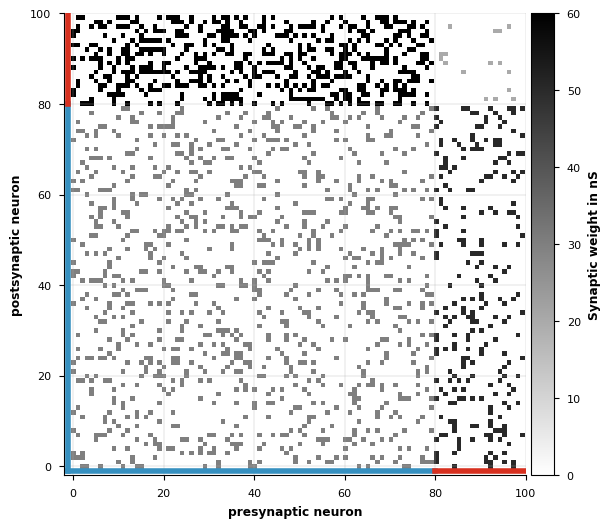

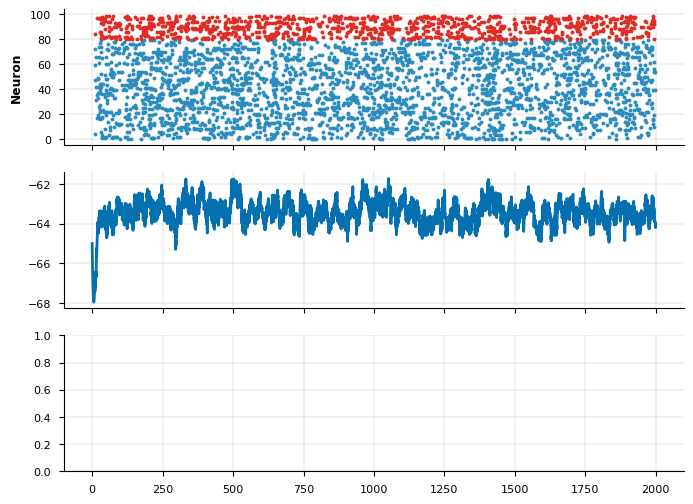

In [27]:
start_scope() # this opens our environment

n_neurons = 100



c_m = 10*nF
r_m = 1*Mohm
tau_m = c_m*r_m
tau_e = 5.26*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -75*mV
v_threshold = -54 *mV
v_reset = -75*mV
g_l = 1/r_m

eqs = '''
dv/dt = (i_e + i_i+ i_l)/c_m : volt
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
i_l = g_l * (E_l - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''

input_excitation = PoissonGroup(n_neurons, rates=100*Hz, dt=0.1*ms)

neurons_exc = NeuronGroup(n_neurons*0.8, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_inh = NeuronGroup(n_neurons*0.2, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_exc.v = -65*mV
neurons_inh.v = -65*mV

excitatory_synapses = Synapses(input_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'excitatory_connections')
excitatory_synapses.connect(condition = 'i==j')
excitatory_synapses.w = 450*nS

inhibitory_synapses = Synapses(input_excitation,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'inhibitory_connections')
inhibitory_synapses.connect(condition = 'i==j')
inhibitory_synapses.w = 450*nS

e_e = Synapses(neurons_exc,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'rec_e_e')
e_e.connect(p=0.15)
e_e.w = 30*nS

i_e = Synapses(neurons_exc,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'rec_i_e')
i_e.connect(p=0.15)
i_e.w = 50*nS

e_i = Synapses(neurons_inh,neurons_exc, 'w : siemens', on_pre = 'g_i += w', name = 'rec_e_i')
e_i.connect(p=0.35)
e_i.w = 60*nS

i_i = Synapses(neurons_inh,neurons_inh, 'w : siemens', on_pre = 'g_i += w', name = 'rec_i_i')
i_i.connect(p=0.05)
i_i.w = 20*nS


W = np.full((n_neurons +2, n_neurons + 2), np.nan) # we always add + 2 to allow color annotations in plot
# Insert the values from the Synapses object
W[e_e.i[:], e_e.j[:]] = e_e.w[:]/nS
W[i_e.i[:], i_e.j[:]+len(neurons_exc)] = i_e.w[:]/nS
W[e_i.i[:]+len(neurons_exc),e_i.j[:]] = e_i.w[:]/nS
W[i_i.i[:]+len(neurons_exc),i_i.j[:]+len(neurons_exc)] = i_i.w/nS


fig, ax = plt.subplots()
im = ax.imshow(W, origin='lower', cmap='binary', vmin=0)
ax.plot([-1,-1],[-1,len(neurons_exc)], color = '#3690c0',linewidth=4)
ax.plot([-1,-1],[len(neurons_exc),n_neurons], color = '#d7301f',linewidth=4)
ax.plot([-1,len(neurons_exc)],[-1,-1], color = '#3690c0',linewidth=4)
ax.plot([len(neurons_exc),n_neurons],[-1,-1], color = '#d7301f',linewidth=4)
divider = make_axes_locatable(ax)
ax.set(
    xlim = (-2,n_neurons),
    ylim = (-2,n_neurons),
    xlabel = 'presynaptic neuron',
    ylabel = 'postsynaptic neuron')
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical', label='Synaptic weight in nS')

plt.savefig('connectivity_matrix.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )


specific_excitation = PoissonGroup(n_neurons*0.1, rates=0*Hz)
specific_syn = Synapses(specific_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'specific_connections')
specific_syn.connect(condition = 'i==j')
specific_syn.w = 4.5*nS


M_e = SpikeMonitor(neurons_exc)
M_i = SpikeMonitor(neurons_inh)
voltage_exc = StateMonitor(neurons_exc, 'v', record=True)
rate_exc = PopulationRateMonitor(neurons_exc)
rate_inh = PopulationRateMonitor(neurons_inh)



run(2000*ms)

fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
ax1.plot(M_e.t/ms, M_e.i, '.', c='#2b8cbe')
ax1.plot(M_i.t/ms, M_i.i+n_neurons*0.8, '.', c='#de2d26')
ax1.set(
    ylabel = 'Neuron')
ax2.plot(voltage_exc.t/ms, np.mean((voltage_exc.v/mV),axis=0))
ax3.plot(rate_inh)
ax3.set(
    xlabel = 'Time in ms')

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I_I) \qquad (1)
\end{align}